In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from scipy.io import loadmat
from skimage.filters import threshold_otsu
import cv2

In [2]:
from deepcardio_utils import *

## Sparks location and image list

In [3]:
mat = loadmat(os.path.join(DATASETS_PATH, MAT_PATH))['xytspark']
sparksDF = pd.DataFrame(mat, columns=['x','y','tIni','tFin'])
sparksDF.head()

,x,y,tIni,tFin
0,71,36,2,37
1,76,37,37,77
2,162,23,81,116
3,207,26,117,152
4,187,10,333,383


In [4]:
imageList = sorted(os.listdir(IMAGE_FOLDER))
imageList[:5]

['170215_RyR-GFP30_RO_01_Serie2_z10000_ch01.tif',
 '170215_RyR-GFP30_RO_01_Serie2_z10001_ch01.tif',
 '170215_RyR-GFP30_RO_01_Serie2_z10002_ch01.tif',
 '170215_RyR-GFP30_RO_01_Serie2_z10003_ch01.tif',
 '170215_RyR-GFP30_RO_01_Serie2_z10004_ch01.tif']

## Plot images and locate sparks

In [5]:
idx = 130
im = get_image_array(idx)
im.shape

(40, 256)

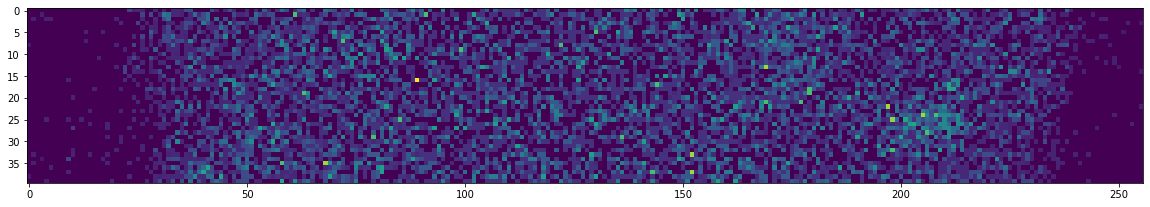

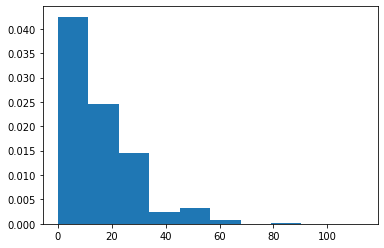

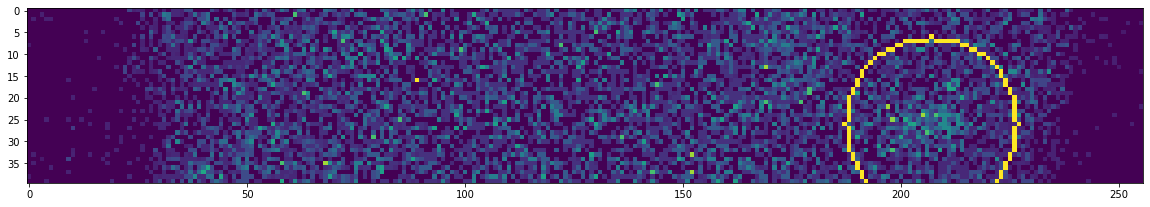

In [6]:
plt.figure(figsize=(20, 10))
plt.imshow(im)
plt.show()

plt.hist(im.flatten(), density=True)
plt.show()

# find spark
im_ = im.copy()
sparkLocation = get_spark_location(sparksDF, idx)
plt.figure(figsize=(20, 10))
color = int(im_.max())
plt.imshow(cv2.circle(im_, (sparkLocation['x'], sparkLocation['y']), 20, color, thickness=1, lineType=8, shift=0))
plt.show()

## Mask on the spark

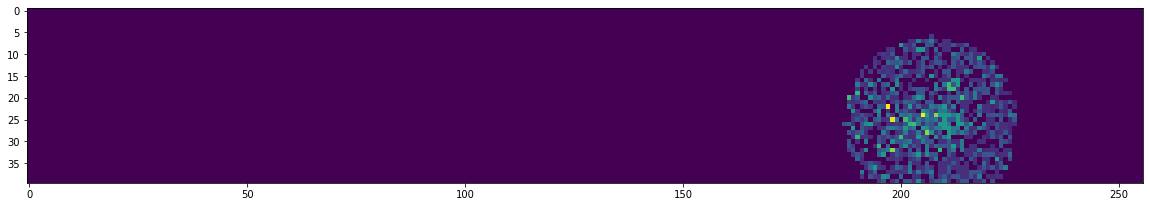

In [7]:
idx = 130
im = get_image_array(idx)
sparkLocation = get_spark_location(sparksDF, idx)
sparkLocation = sparkLocation.loc[sparkLocation.index[0]]
mask = get_mask(im.shape[0], im.shape[1], sparkLocation['x'], sparkLocation['y'], 20)
im[mask == False]=0

plt.figure(figsize=(20, 10))
plt.imshow(im)
plt.show()

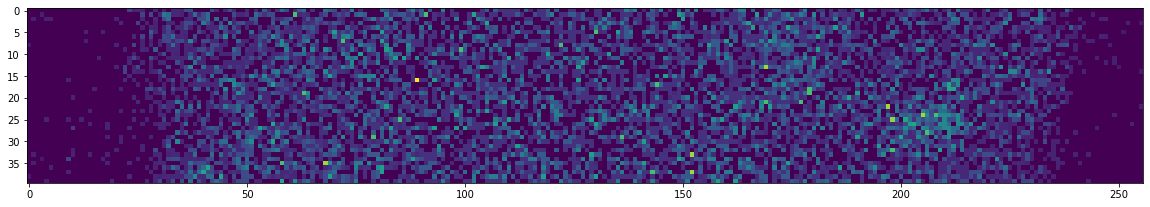

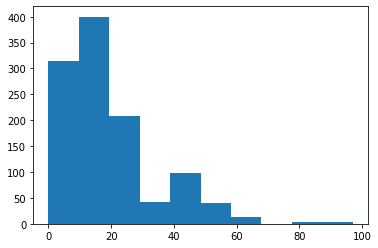

16


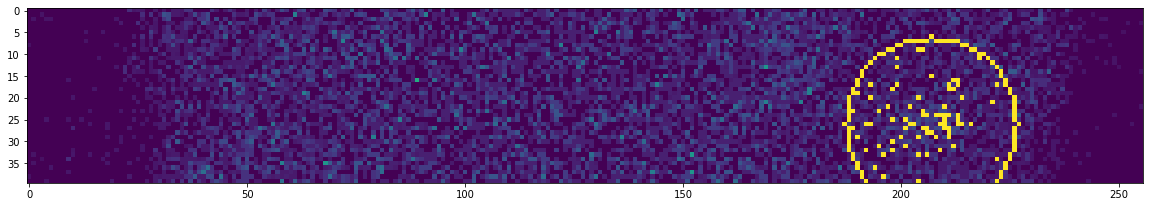

In [8]:
idx = 130
im = get_image_array(idx)
im.shape

plt.figure(figsize=(20, 10))
plt.imshow(im)
plt.show()

mask = get_mask(im.shape[0], im.shape[1], sparkLocation['x'], sparkLocation['y'], 20)

plt.hist(im[mask].flatten())
plt.show()

otsu = threshold_otsu(im[mask].flatten())
print(otsu)
im[mask] = np.where(im[mask]>40, 3000, im[mask])

# find spark
im_ = im.copy()
sparkLocation = get_spark_location(sparksDF, idx)
plt.figure(figsize=(20, 10))
color = int(im_.max())
plt.imshow(cv2.circle(im_, (sparkLocation['x'], sparkLocation['y']), 20, color, thickness=1, lineType=8, shift=0))
plt.show()

## Normaization 
$F_0 = mean(F \in cell | \forall frames)$  
$F_n = \frac{F-F_0}{F_0}$

### Build cell mask

In [9]:
BACKGROUND_MAX_VALUE = 0

cellMask = np.zeros(get_image_array(0).shape)
for i in range(len(imageList)):
    im1 = get_image_array(i)
    auxMask = im1 > BACKGROUND_MAX_VALUE
    cellMask += auxMask

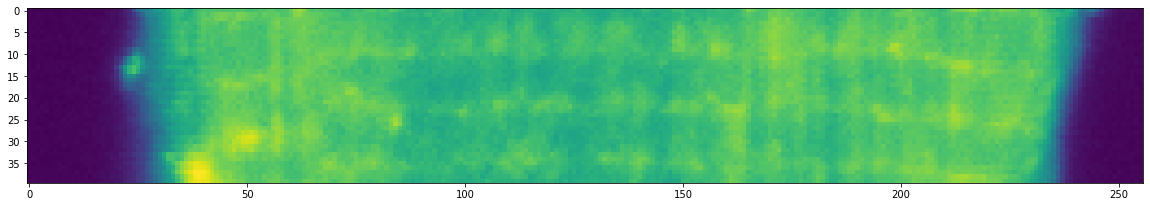

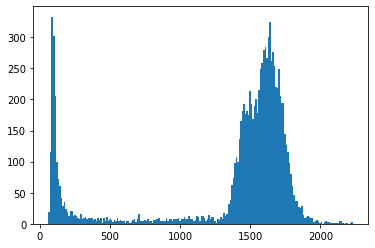

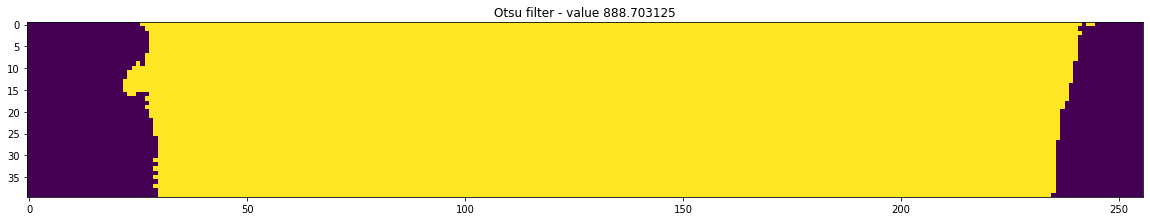

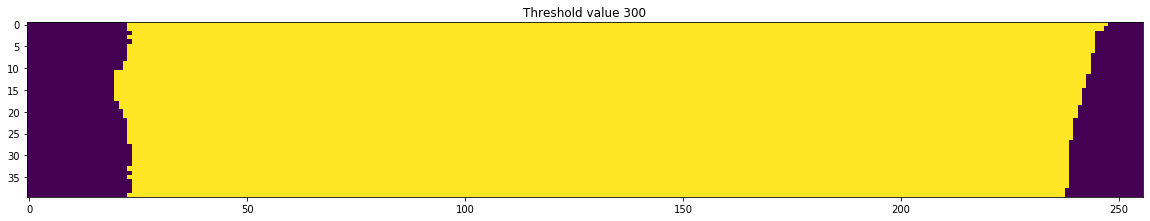

In [10]:
# cellMask = im1 > BACKGROUND_MAX_VALUE
plt.figure(figsize=(20, 10))
plt.imshow(cellMask)
plt.show()

plt.hist(cellMask.flatten(), bins=200)
plt.show()

plt.figure(figsize=(20, 10))
thr = threshold_otsu(cellMask)
plt.imshow(cellMask > thr)
plt.title(f'Otsu filter - value {thr}')
plt.show()

plt.figure(figsize=(20, 10))
thr = 300
plt.imshow(cellMask > thr)
plt.title(f'Threshold value {thr}')
plt.show()

In [11]:
cellMask = cellMask > threshold_otsu(cellMask)

### Value counts

In [12]:
res = pd.Series(dtype='int')
for i in range(len(imageList)):
    im1 = get_image_array(i)
    s1 = pd.Series(im1[cellMask].flatten())
    g1 = s1.groupby(s1).size()
    
    res = pd.concat([res, g1], axis=1).fillna(0, downcast='infer').sum(axis=1)

# res

### F0

In [13]:
F0 = (res*res.index).sum()/res.sum()
F0

15.179870023905599

In [14]:
F0, cellMask = get_f0_and_cellmask()

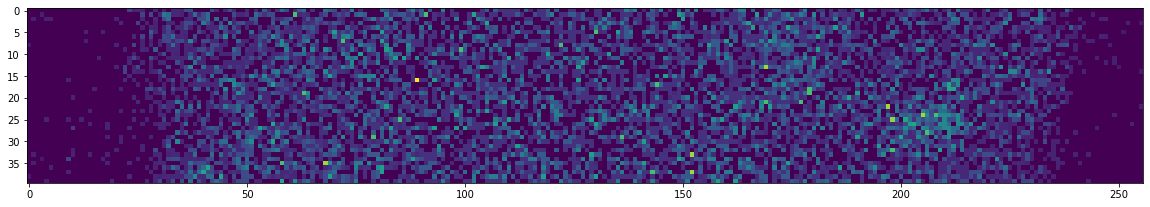

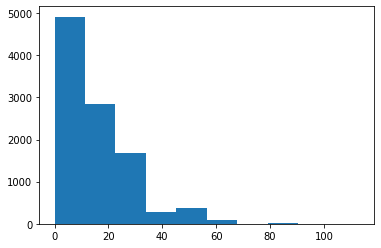

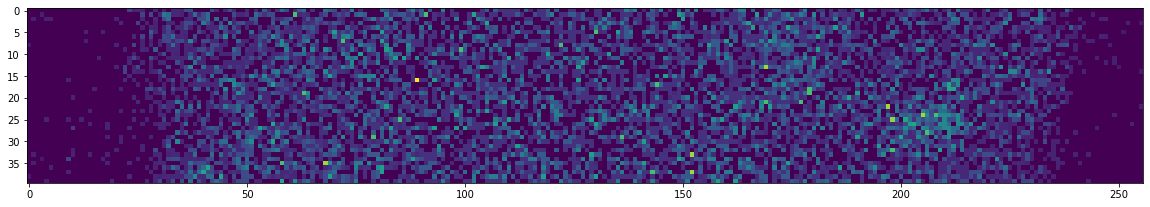

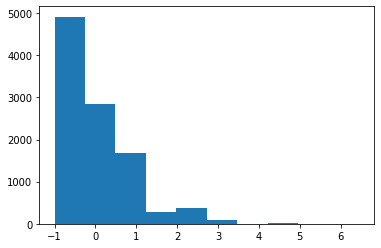

In [15]:
idx = 130
im = get_image_array(idx)

plt.figure(figsize=(20, 10))
plt.imshow(im)
plt.show()

plt.hist(im.flatten())
plt.show()

im = get_normalized_frame(im, F0)

plt.figure(figsize=(20, 10))
plt.imshow(im)
plt.show()

plt.hist(im.flatten())
plt.show()